# Import Corresponding Packages

In [45]:
import os
import boto3
import sagemaker
import pandas as pd
import numpy as np
import csv, json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML, display, Image as IImage
from io import StringIO
from pyathena import connect
from sklearn.model_selection import train_test_split
import warnings

from PIL import Image
from skimage import transform
from sklearn.utils import shuffle

warnings.filterwarnings('ignore')

In [10]:
# Initialize Boto3 Rekognition client

rekognition_client = boto3.client("rekognition")
s3 = boto3.client("s3")

# Detect labels in Traffic sign images

In [52]:
# Define s3 bucket name, prefix and output csv file path

bucket_name = 'final.project.data.508'
prefix_key = 'traffic_signs/'
output_csv_key = 'csv_files/traffic_signs.csv'

In [53]:
# Function to detect text from an image 

def detect_text_from_image(bucket_name, image_key):
    if image_key.endswith('.jpg'):
        rekognition_response = rekognition_client.detect_text(Image={'S3Object': {'Bucket': bucket_name, 'Name': image_key}})
        return rekognition_response

In [54]:
# Get a list of objects in the s3 bucket

all_results = []

paginator = s3.get_paginator('list_objects_v2')
result = paginator.paginate(Bucket=bucket_name, Prefix=prefix_key)

for page in result:
    if "Contents" in page:
         for key in page[ "Contents" ]:
             keyString = key[ "Key" ]
             print(keyString)
             if keyString.endswith('.jpg'):
                 response = detect_text_from_image(bucket_name, keyString)
                 all_results.append({'Image': keyString, 'TextDetections': response['TextDetections']})

In [58]:
# # Write aggregated results to a single CSV file

csv_buffer = StringIO()
writer = csv.DictWriter(csv_buffer, fieldnames=['Image', 'DetectedText', 'Type', 'Confidence'])
writer.writeheader()
for result in all_results:
    image_key = result['Image']
    for detection in result['TextDetections']:
        detected_text = detection['DetectedText']
        text_type = detection['Type']
        confidence = detection['Confidence']
        writer.writerow({'Image': image_key, 'DetectedText': detected_text, 'Type': text_type, 'Confidence': confidence})
        
# # Upload CSV string to S3

csv_buffer.seek(0)
s3.put_object(Body=csv_buffer.getvalue(), Bucket=bucket_name, Key=output_csv_key)

print(f"Text detection results saved to: s3://{bucket_name}/{output_csv_key}")

Text detection results saved to: s3://final.project.data.508/csv_files/traffic_signs.csv


In [59]:
# Create athena database

sess = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sess.default_bucket()
region = boto3.Session().region_name

ingest_create_athena_db_passed = False

In [60]:
# Set Athena database name

database_name = "velocityvision"

In [61]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries

s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [62]:
# Connect to s3 using PyAthena

conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [63]:
# SQL statement to execute

statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
print(statement)
pd.read_sql(statement, conn)

CREATE DATABASE IF NOT EXISTS velocityvision


""


In [64]:
input_data_location = "s3://finalprojectdata/csv_files"

In [65]:
# SQL statement to execute the traffic signs text detection

table_name1 = 'traffic_signs'
pd.read_sql(f'DROP TABLE IF EXISTS {database_name}.{table_name1}', conn)

create_table = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name1}(
            image_id string,
            detected_text string,
            type string,
            confidence float
            )
            
            ROW FORMAT DELIMITED FIELDS TERMINATED BY ','
            LOCATION '{input_data_location}'
            TBLPROPERTIES ('skip.header.line.count'='1')
"""

pd.read_sql(create_table, conn)

pd.read_sql(f'SELECT * FROM {database_name}.{table_name1} LIMIT 5', conn)

,image_id,detected_text,type,confidence
0,traffic_signs/000000_jpg.rf.b11f308f16626f9f79...,30,LINE,99.548250
1,traffic_signs/000000_jpg.rf.b11f308f16626f9f79...,RYARSH,LINE,99.415030
2,traffic_signs/000000_jpg.rf.b11f308f16626f9f79...,Please reduce,LINE,99.164894
3,traffic_signs/000000_jpg.rf.b11f308f16626f9f79...,your speed,LINE,99.207320
4,traffic_signs/000000_jpg.rf.b11f308f16626f9f79...,30,WORD,99.548250


In [66]:
# SQL statement to filter rows for "WORD" type

query1 = "SELECT * FROM {}.{} WHERE type='WORD'".format(database_name, table_name1)
traffic_signs_df = pd.read_sql(query1, conn)

In [67]:
traffic_signs_df.shape

(15968, 4)

## Checking duplicate values

In [68]:
traffic_signs_df.duplicated().sum()

7993

In [69]:
# Removing duplicate rows

traffic_signs_df.drop_duplicates(inplace = True)
traffic_signs_df.shape

(7975, 4)

In [70]:
traffic_df = traffic_signs_df.groupby(['image_id', 'type']).agg({'detected_text': ' '.join, 'confidence':'max'}).reset_index()
traffic_df.head()

,image_id,type,detected_text,confidence
0,traffic_signs/000000_jpg.rf.b11f308f16626f9f79...,WORD,30 RYARSH Please reduce your speed,99.548250
1,traffic_signs/000005_jpg.rf.d730849ae93a7c211a...,WORD,T lamy STEEP - a T 30 alamy a alamy 20 is plen...,99.875980
2,traffic_signs/000007_jpg.rf.226fe0751cf8ba445b...,WORD,30,99.148350
3,traffic_signs/000008_jpg.rf.bd6ae6db0f8c0eb727...,WORD,30 stock.photo www.alamy.com-DB9EAN,97.540085
4,traffic_signs/000009_jpg.rf.df4118d1d26fa7a259...,WORD,3010 www.alamy.com - EKPJRP,87.884930


In [71]:
# SQL statement to execute the analysis of vehicle speed

table_name2 = 'vehicle_speed'
pd.read_sql(f'DROP TABLE IF EXISTS {database_name}.{table_name2}', conn)

create_table = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {database_name}.{table_name2}(
             latitude float,
             longitude float,
             target_speed float,
             way_maxspeed float,
             speed_osrm float,
             elevation float,
             fwd_azimuth float,
             way_type string,
             way_surface string,
             node_intersection string,
             node_railway string,
             node_crossing string,
             node_highway string,
             node_stop string,
             start_stop int,
             azimuth_diff int,
             elevation_diff float
             )
             
             ROW FORMAT DELIMITED FIELDS TERMINATED BY ','
             LOCATION 's3://finalprojectdata/vehicle_speed'
             TBLPROPERTIES ('skip.header.line.count'='1')
"""

pd.read_sql(create_table, conn)

""


In [72]:
vehicle_speed_df = pd.read_sql(f'SELECT * FROM {database_name}.{table_name2}', conn)
vehicle_speed_df.head()

,latitude,longitude,target_speed,way_maxspeed,speed_osrm,elevation,fwd_azimuth,way_type,way_surface,node_intersection,node_railway,node_crossing,node_highway,node_stop,start_stop,azimuth_diff,elevation_diff
0,50.397060,14.913273,39.739456,130.0,28.837246,229.77516,46.24135,motorway,asphalt,,,,,,0,0.0,-0.025587
1,50.397068,14.913283,39.717785,130.0,28.875628,229.74959,46.24135,motorway,asphalt,,,,,,0,0.0,-0.025587
2,50.397076,14.913294,39.696114,130.0,28.914007,229.72400,46.24135,motorway,asphalt,,,,,,0,0.0,-0.025587
3,50.397080,14.913303,39.674442,130.0,28.952387,229.69841,46.24135,motorway,asphalt,,,,,,0,0.0,-0.025587
4,50.397087,14.913314,39.652770,130.0,28.990767,229.67282,46.24135,motorway,asphalt,,,,,,0,0.0,-0.025587


## Conducting Data Cleansing Techniques

In [51]:
# First copied the files from a public to private bucket
# List the contents of the public bucket
# !aws s3 ls s3://finalprojectdata/

# Create folders in your private bucket for each type of data
# !aws s3 mb s3://final.project.data.508/vehicle_type
# !aws s3 mb s3://final.project.data.508/license_plate
# !aws s3 mb s3://final.project.data.508/traffic_signage
# !aws s3 mb s3://final.project.data.508/vehicle_speed

# Copy the contents of each folder from the public bucket to your private bucket
# !aws s3 cp s3://finalprojectdata/cars_type/ s3://final.project.data.508/vehicle_type/ --recursive
# !aws s3 cp s3://finalprojectdata/traffic_signs/ s3://final.project.data.508/traffic_signage/ --recursive
# !aws s3 cp s3://finalprojectdata/license_plate/ s3://final.project.data.508/license_plate/ --recursive
# !aws s3 cp s3://finalprojectdata/vehicle_speed/ s3://final.project.data.508/vehicle_speed/ --recursive

In [79]:
# Function to read the dataset from S3
def read_dataset_from_s3(bucket, prefix, filename):
    s3 = boto3.resource('s3')
    obj = s3.Object(bucket, os.path.join(prefix, filename))
    data = obj.get()['Body'].read().decode('utf-8')
    return pd.read_csv(io.StringIO(data))

# Function to resize images
def resize_image(image, target_size):
    return transform.resize(image, target_size)

# Function to normalize pixel values
def normalize_image(image):
    return image / 255.0

# Function to perform data inspection & cleaning
def inspect_and_clean_data(data):
    # Display basic information
    print("Dataset shape:", data.shape)
    print("Data types:\n", data.dtypes)
    print("Sample records:\n", data.head())

    # Handle missing values
    data.dropna(inplace=True)

    # Remove duplicate records
    data.drop_duplicates(inplace=True)

    return data

# Function to perform data augmentation
def augment_data(images, labels, augment_factor):
    augmented_images = []
    augmented_labels = []

    for image, label in zip(images, labels):
        augmented_images.append(image)
        augmented_labels.append(label)

        # Apply transformations and add augmented samples
        for _ in range(augment_factor):
            augmented_image = apply_random_augmentation(image)
            augmented_images.append(augmented_image)
            augmented_labels.append(label)

    return np.array(augmented_images), np.array(augmented_labels)

# Set the bucket & prefix for the dataset location
bucket = 'final.project.data.508'
prefix = 'traffic_signs/'
image_path = 's3://final.project.data.508/traffic_signage/'


# Perform data inspection and cleaning
cleaned_data = inspect_and_clean_data(traffic_df)

# Resize images to a uniform size
target_size = (32, 32)
resized_images = np.array([resize_image(np.array(Image.open(image_path)), target_size) 
                           for image_path in cleaned_data['image_id']])

# Normalize pixel values
normalized_images = np.array([normalize_image(image) for image in resized_images])

# Perform data augmentation (example with augment_factor=2)
augmented_images, augmented_labels = augment_data(normalized_images, 
                                                  cleaned_data['type'], 
                                                  augment_factor=2)

# Shuffle the augmented data
augmented_images, augmented_labels = shuffle(augmented_images, augmented_labels)

# Optionally, save the preprocessed data for training
np.save('augmented_images.npy', augmented_images)
np.save('augmented_labels.npy', augmented_labels)

Dataset shape: (2200, 4)
Data types:
 image_id          object
type              object
detected_text     object
confidence       float64
dtype: object
Sample records:
                                             image_id  type  \
0  traffic_signs/000000_jpg.rf.b11f308f16626f9f79...  WORD   
1  traffic_signs/000005_jpg.rf.d730849ae93a7c211a...  WORD   
2  traffic_signs/000007_jpg.rf.226fe0751cf8ba445b...  WORD   
3  traffic_signs/000008_jpg.rf.bd6ae6db0f8c0eb727...  WORD   
4  traffic_signs/000009_jpg.rf.df4118d1d26fa7a259...  WORD   

                                       detected_text  confidence  
0                 30 RYARSH Please reduce your speed   99.548250  
1  T lamy STEEP - a T 30 alamy a alamy 20 is plen...   99.875980  
2                                                 30   99.148350  
3                30 stock.photo www.alamy.com-DB9EAN   97.540085  
4                        3010 www.alamy.com - EKPJRP   87.884930  


FileNotFoundError: [Errno 2] No such file or directory: 'traffic_signs/000000_jpg.rf.b11f308f16626f9f795a148029c46d10.jpg'

# Exploratory Data Analysis

### Velocity Dataset

In [3]:
# Load csv from S3 bucket

# Import req'd packages
import pandas as pd
import boto3

# Define S3 bucket and key
bucket = 'velocityspeedproject08'
key = 'datasets/vehicle_speed/vehicle_speed.csv'

# Create a S3 client
s3 = boto3.client('s3')

# Load dataset from S3
obj = s3.get_object(Bucket=bucket, Key=key)
df = pd.read_csv(obj['Body'])

# Preview dataset
df.head()

,latitude,longitude,target_speed,way_maxspeed,speed_osrm,elevation,fwd_azimuth,way_type,way_surface,node:intersection,node:railway,node:crossing,node:highway,node:stop,start_stop,azimuth_diff,elevation_diff
0,50.397062,14.913273,39.739457,130.0,28.837247,229.775169,46.241347,motorway,asphalt,NaN,NaN,NaN,NaN,NaN,0,0.0,-0.025587
1,50.397068,14.913283,39.717786,130.0,28.875627,229.749582,46.241347,motorway,asphalt,NaN,NaN,NaN,NaN,NaN,0,0.0,-0.025587
2,50.397074,14.913294,39.696114,130.0,28.914007,229.723996,46.241347,motorway,asphalt,NaN,NaN,NaN,NaN,NaN,0,0.0,-0.025587
3,50.397080,14.913304,39.674442,130.0,28.952387,229.698409,46.241347,motorway,asphalt,NaN,NaN,NaN,NaN,NaN,0,0.0,-0.025587
4,50.397087,14.913314,39.652771,130.0,28.990767,229.672822,46.241347,motorway,asphalt,NaN,NaN,NaN,NaN,NaN,0,0.0,-0.025587


In [4]:
# Determine shape of df
df.shape

(12165, 17)

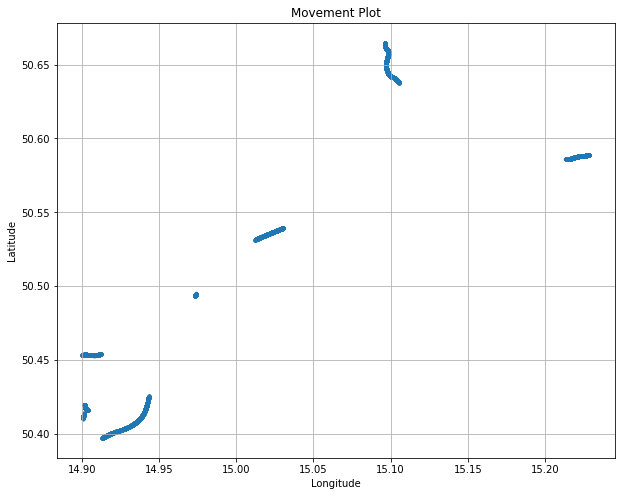

In [5]:
# Plot movement using latitude and longitude
plt.figure(figsize=(10, 8))
plt.scatter(df['longitude'], df['latitude'], alpha=0.5, marker='.')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Movement Plot')
plt.grid(True)
plt.show()

In [6]:
# Define S3 bucket and key
bucket = 'velocityspeedproject08'
key = 'datasets/vehicle_speed/combined_dataset.csv'

# Create a S3 client
s3 = boto3.client('s3')

# Load dataset from S3
obj = s3.get_object(Bucket=bucket, Key=key)
upd_df = pd.read_csv(obj['Body'])

# Preview dataset
upd_df.head()

,latitude,longitude,target_speed,way_maxspeed,speed_osrm,elevation,fwd_azimuth,way_type,way_surface,node:intersection,node:railway,node:crossing,node:highway,node:stop,start_stop,azimuth_diff,elevation_diff,IdentifyingValue
0,50.515393,14.966795,18.272307,90.0,18.2,232.000000,116.775715,secondary,asphalt,NaN,NaN,NaN,NaN,NaN,1,0.0,0.000000,98
1,50.515389,14.966808,18.272307,90.0,18.2,232.054728,116.775715,secondary,asphalt,NaN,NaN,NaN,NaN,NaN,0,0.0,0.054728,98
2,50.515385,14.966820,18.272307,90.0,18.2,232.109455,116.775715,secondary,asphalt,NaN,NaN,NaN,NaN,NaN,0,0.0,0.054728,98
3,50.515381,14.966833,18.272307,90.0,18.2,232.164183,116.775715,secondary,asphalt,NaN,NaN,NaN,NaN,NaN,0,0.0,0.054728,98
4,50.515377,14.966845,18.272307,90.0,18.2,232.218911,116.775715,secondary,asphalt,NaN,NaN,NaN,NaN,NaN,0,0.0,0.054728,98


In [7]:
# Determine shape of df
upd_df.shape

(864906, 18)

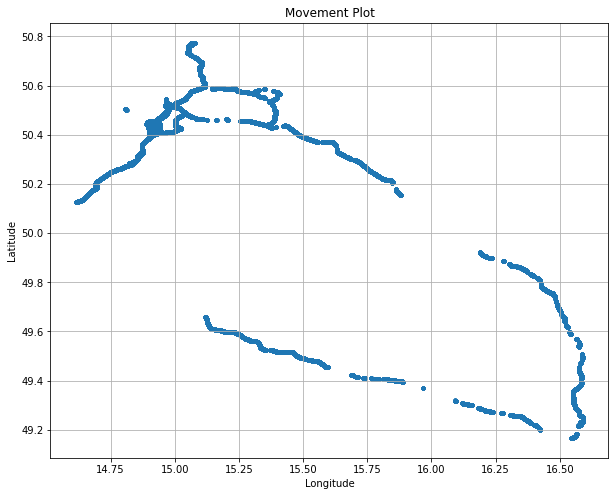

In [8]:
# Plot movement using latitude and longitude
plt.figure(figsize=(10, 8))
plt.scatter(upd_df['longitude'], upd_df['latitude'], alpha=0.5, marker='.')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Movement Plot')
plt.grid(True)
plt.show()

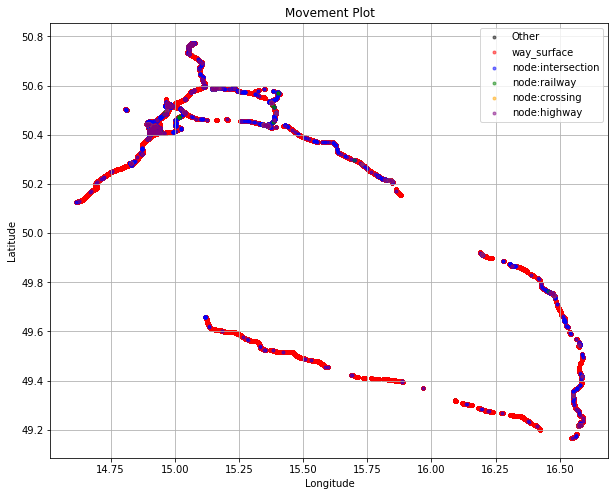

In [9]:
# Define colors for different columns
color_map = {
    'way_surface': 'red',
    'node:intersection': 'blue',
    'node:railway': 'green',
    'node:crossing': 'orange',
    'node:highway': 'purple'
}

# Plot movement using latitude and longitude
plt.figure(figsize=(10, 8))

# Scatter plot for latitude & longitude
plt.scatter(upd_df['longitude'], upd_df['latitude'], alpha=0.5, marker='.', color='black', label='Other')

# Scatter plot for desired columns
for column, color in color_map.items():
    if column in upd_df.columns:
        plt.scatter(upd_df[upd_df[column].notnull()]['longitude'], 
                    upd_df[upd_df[column].notnull()]['latitude'], 
                    alpha=0.5, marker='.', color=color, label=column)

# Add labels & title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Movement Plot')

# Show legend
plt.legend()

plt.grid(True)
plt.show()

In [29]:
vehicle_speed_df.shape

(12165, 17)

Text(0, 0.5, 'Count')

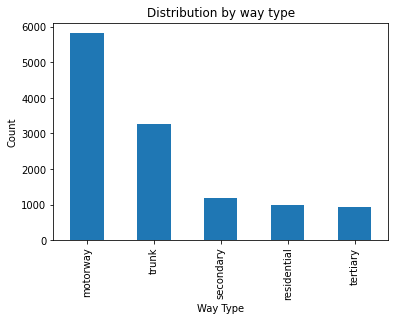

In [30]:
# Distrubition by Way type

vehicle_speed_df['way_type'].value_counts().plot(kind="bar", title="Distribution by way type")
plt.xlabel("Way Type")
plt.ylabel("Count")

# Correlation

Lets study the correlation between different attributes in the dataset

<AxesSubplot:>

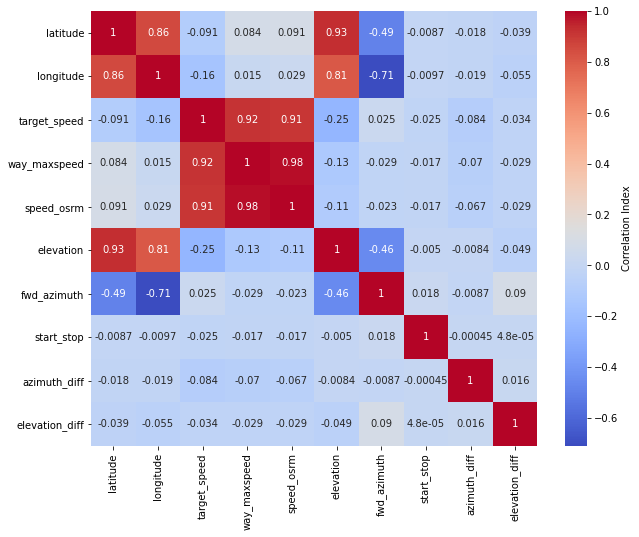

In [31]:
corr = vehicle_speed_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap = 'coolwarm', cbar_kws={'label': 'Correlation Index'})

From the above correlation Heatmap, it is observed that the below predictors are highly correlated.
(1) latitude and elevation
(2) target_speed and way_maxspeed
(3) way_maxspeed and speed_osrm
(4) target_speed and elevation

# 2. Data Preprocessing

## 2.1. Handling Missing Values

In [32]:
vehicle_speed_df.isnull().sum()

latitude             0
longitude            0
target_speed         0
way_maxspeed         0
speed_osrm           0
elevation            0
fwd_azimuth          0
way_type             0
way_surface          0
node_intersection    0
node_railway         0
node_crossing        0
node_highway         0
node_stop            0
start_stop           0
azimuth_diff         7
elevation_diff       0
dtype: int64

In [33]:
# Dropping columns that have null values

vehicle_speed_df = vehicle_speed_df.drop(['node_intersection', 'node_railway', 'node_crossing', 'node_highway', 'node_stop'], axis=1)

# Dropping rows that have null values

vehicle_speed_df = vehicle_speed_df.dropna(subset=['azimuth_diff'])

# Multicollinearity

Lets address the multicollinearity issue by calculating Variance Inflation Factor (VIF) and removing highly correlated predictors.

In [34]:
# Separate the predictors and target variables

X_pred = vehicle_speed_df.drop(['target_speed'], axis=1)
y_target = vehicle_speed_df['target_speed']

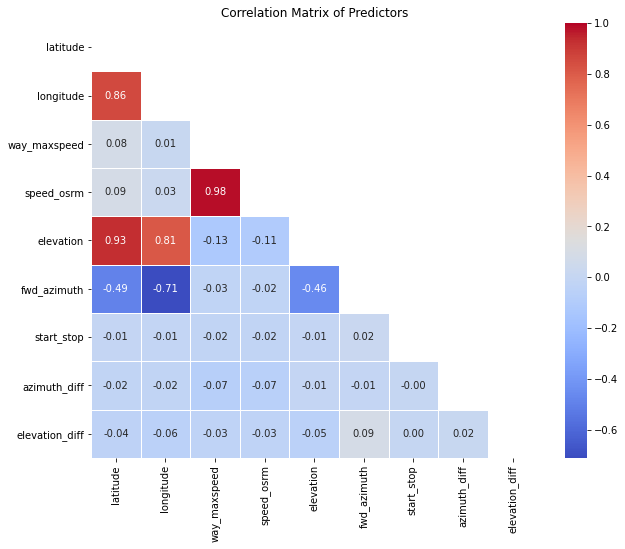

In [35]:
# Calculate correlation matrix for predictors
correlation_matrix = X_pred.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Predictors')
plt.show()

To address the issue of multicollinearity, it is suggested to remove the columns longitude, way_maxspeed, and elevation. However, since determining the target speed of a vehicle relies on multiple factors, including spatial information about the vehicle's location, both latitude and longitude should be taken into account.

# Feature transformation

The maximum allowed speed is measured in km/hr whereas target_speed and speed_osrm are measured in m/s. Hence transforming the target_speed and speed_osrm values to km/hr

In [36]:
# Convert m/s to km/hr for the target_speed and speed_osrm column

vehicle_speed_df['target_speed'] = vehicle_speed_df['target_speed'] * 3.6

vehicle_speed_df['speed_osrm'] = vehicle_speed_df['speed_osrm'] * 3.6

# Feature Creation

Lets create a new feature speed_deviation that computes the difference between target_speed and way_maxspeed to see if the vehicle is driving above or below the allowed speed limit.

In [37]:
vehicle_speed_df['speed_deviation'] = vehicle_speed_df['target_speed'] - vehicle_speed_df['way_maxspeed']

# Drop Irrelevant fields

In [38]:
# Dropping fields that exhibit multicollinearity 

vehicle_speed_df = vehicle_speed_df.drop(['way_maxspeed', 'elevation'], axis=1)

# Dropping irrelevant columns

vehicle_speed_df = vehicle_speed_df.drop(['fwd_azimuth', 'way_surface', 'start_stop', 'azimuth_diff', 'elevation_diff'], axis=1)

# Feature Selection

Based on the insights from the correlation matrix heatmap and other transformation techniques, the useful predictors for the final model include: latitude, longitude, speed_osrm, way_type, speed_deviation and target_speed.

In [39]:
final_df = vehicle_speed_df.copy()

# Encoding Categorical Variables

In [40]:
# Convert categorical variables to dummy variables

final_df = pd.get_dummies(final_df, columns= ['way_type'], drop_first=True)
final_df.head()

,latitude,longitude,target_speed,speed_osrm,speed_deviation,way_type_residential,way_type_secondary,way_type_tertiary,way_type_trunk
0,50.397060,14.913273,143.062042,103.814086,13.062042,0,0,0,0
1,50.397068,14.913283,142.984026,103.952261,12.984026,0,0,0,0
2,50.397076,14.913294,142.906010,104.090425,12.906010,0,0,0,0
3,50.397080,14.913303,142.827991,104.228593,12.827991,0,0,0,0
4,50.397087,14.913314,142.749972,104.366761,12.749972,0,0,0,0


# Data Partitioning

## Separate predictor and target variables

In [41]:
# Separate X and y variables

X = final_df.drop(['target_speed'], axis=1)
y = final_df['target_speed']
predictors = X.columns
outcome = 'target_speed'

## Split dataset into training, test and validation sets

In [42]:
# Split the training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

# Split the test and validation set
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

In [43]:
# Proportions of training, test and validation data

train_prop = len(X_train)/len(final_df)
test_prop = len(X_test)/len(final_df)
valid_prop = len(X_valid)/len(final_df)

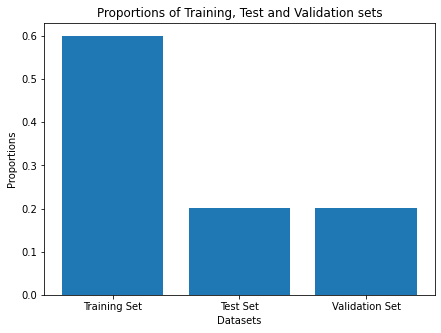

In [44]:
plt.figure(figsize=(7,5))
labels = ['Training Set', 'Test Set', 'Validation Set']
proportions = [train_prop, test_prop, valid_prop]
plt.bar(labels,proportions)
plt.xlabel("Datasets")
plt.ylabel("Proportions")
plt.title("Proportions of Training, Test and Validation sets")
plt.show()